# STARR SEQ 6/29 - 7/2 RUN REPORT #

### LOAD DATA ###

In [1]:
import pandas as pd
import numpy as np
import re

In [6]:
#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/cluster/bh0085/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])


In [2]:
import z2_save_jaspar
jaspar= z2_save_jaspar.load_jaspar()
import z1_save_oligos
oligos,oligos_by_exp = z1_save_oligos.load_oligos()

MODERATE_EXPR_MU = 15
HIGH_EXPR_MU = 50
EXP_MODERATE_EXPR_MU = 3.3

### IDENTIFY ENHANCERS IN POOLED DATA ###

In [3]:
def get_enriched_oligos(oligos_df, MU_THRESHOLD):
    #categorize oligo groups by mean expression

    oligos_lib = z1_save_oligos.oligos_lib
    unique_starts = pd.DataFrame(pd.Series(oligos_lib.starts.unique()).rename("starts"))
    start_indexes = unique_starts.reset_index().set_index("starts")

    starts_by_mean_expression = oligos_df.groupby("start_index").mu.mean().sort_values(ascending=False)
    enriched_oligo_starts = starts_by_mean_expression.loc[(starts_by_mean_expression>=MU_THRESHOLD)]
    enriched_oligo_start_positions =unique_starts.loc[enriched_oligo_starts.index].starts
    enriched_oligo_start_neighborhoods = pd.concat([enriched_oligo_start_positions + i * 30 for i in range(-2,3)])

    oligos_by_start = oligos.reset_index().set_index("starts").sort_index()
    active_oligos = oligos_by_start.loc[oligos_by_start.groupby(level=0).size() == 5]
    enriched_oligos = active_oligos.loc[active_oligos.index.isin(enriched_oligo_start_positions)]
    enriched_motif_candidates  = enriched_oligos.loc[enriched_oligos.groupby(level=0).apply(lambda x: x.mu.loc[x.mu > (x.mu.mean() - x.mu.std())].count() ==4)].groupby(level=0).apply(lambda x:x.sort_values("mu",ascending=True).iloc[0])
    enriched_oligos = enriched_oligos.reset_index().set_index("oligo")
    
    return enriched_oligos

def get_enhancers(enriched_oligos):
    oligo_candidates = enriched_oligos
    candidate_min_mutant_nums = oligo_candidates.reset_index().groupby("starts").apply(lambda x: x.sort_values("mu").iloc[0].mutant_num)

    enhancer_mutant_candidates=  oligo_candidates.loc[
        (oligo_candidates.starts.isin(candidate_min_mutant_nums.index[candidate_min_mutant_nums>0]))
    ]
    candidates_by_start = enhancer_mutant_candidates.reset_index().groupby("starts").apply(lambda x: x.sort_values("mu").iloc[0])
    candidates_by_start["wt_sequence"] = oligo_candidates.loc[oligo_candidates.mutant_num==0].set_index("starts").Sequences
    enhancer_mut_sequences_by_start = pd.concat([
        candidates_by_start.apply(lambda x: x.wt_sequence[int((x.mutant_num-1) *30 ):int((x.mutant_num-1) *30+30)],axis=1).rename("seq"),
        candidates_by_start.wt_sequence,
        candidates_by_start.oligo,
        candidates_by_start.apply(lambda x: x.name,axis = 1).rename("start"),
        (candidates_by_start.apply(lambda x: x.name,axis = 1) + (candidates_by_start.mutant_num-1)*30).rename("mutant_start")  
    ],axis =1)
    return enhancer_mut_sequences_by_start



### ANALYZE MOTIFS ###

In [4]:
enriched_oligos =  get_enriched_oligos(oligos, MODERATE_EXPR_MU)
enhancer_mut_sequences_by_start = get_enhancers(enriched_oligos)
pooled_enhancers = enhancer_mut_sequences_by_start.rename_axis("starts",axis="index").reset_index()

exp_enhancers = pd.DataFrame()
for k,exp_oligos in oligos_by_exp.groupby("exp"):
    these_oligos = exp_oligos.reset_index(level=0)
    exp_enriched_oligos = get_enriched_oligos(these_oligos, EXP_MODERATE_EXPR_MU)
    exp_enhancer_mut_sequences_by_start = get_enhancers(exp_enriched_oligos)
    exp_enhancer_mut_sequences_by_start["exp"] = k
    exp_enhancer_mut_sequences = exp_enhancer_mut_sequences_by_start.rename_axis("starts", axis="index").reset_index()
    exp_enhancers = exp_enhancers.append(exp_enhancer_mut_sequences,ignore_index=True)
    
all_enhancer_candidates = pd.concat([pooled_enhancers, exp_enhancers], ignore_index = True)


/cluster/bh0085/anaconda27/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:

all_enhancer_candidates["60bp_sequence"] = all_enhancer_candidates.mutant_start.apply(lambda x:chrseq[x-15+38699734:x-15+60+38699734])
all_30bp_enhancer_sequences = all_enhancer_candidates.drop_duplicates(subset=["seq"]).seq.rename_axis("id",axis="index")
all_60bp_enhancer_sequences = all_enhancer_candidates.drop_duplicates(subset=["seq"])["60bp_sequence"].rename_axis("id",axis="index")


In [12]:
all_enhancer_candidates[["exp","60bp_sequence"]].rename({"60bp_sequence":"seq"},axis="columns").\
    to_csv("../data/0711_fewerregions_with_exps.csv")

In [ ]:
from Bio import Seq, Alphabet
seqseq  = all_60bp_enhancer_sequences.apply(lambda x: Seq.Seq(x,alphabet=Alphabet.IUPAC.IUPACUnambiguousDNA()))
pwm_prod_grid = jaspar.pssm.apply(lambda  pssm: seqseq.apply(lambda x:  sorted(pssm.search(x),key=lambda x:-1*x[1])))
pwm_scores_grid = pwm_prod_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][1]).unstack().T
pwm_indices_grid = pwm_prod_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][0]).unstack().T
max_motif_ids = pd.DataFrame(pwm_scores_grid.idxmax().rename("jaspar_id"))

pwm_scores_grid2 = pwm_scores_grid.copy()
pwm_scores_grid2.columns = all_60bp_enhancer_sequences

#ok_motif_hits = decent_motif_hits = pwm_scores_grid2.apply(lambda x: x / jaspar.threshold_patser).where(lambda x: x>1).reset_index().melt(id_vars =["jaspar_id"]).dropna()
ok_motif_hits = pwm_scores_grid2.apply(lambda x: x / jaspar.threshold_patser).where(lambda x: x>1).reset_index().melt(id_vars =["jaspar_id"]).dropna().set_index("60bp_sequence")[["jaspar_id"]]
decent_motif_hits = pwm_scores_grid2.apply(lambda x: x / jaspar.threshold_patser).where(lambda x: x>2).reset_index().melt(id_vars =["jaspar_id"]).dropna().set_index("60bp_sequence")[["jaspar_id"]]
great_motif_hits = pwm_scores_grid2.apply(lambda x: x / jaspar.threshold_patser).where(lambda x: x>4).reset_index().melt(id_vars =["jaspar_id"]).dropna().set_index("60bp_sequence")[["jaspar_id"]]

decent_motif_hits.index.name = "seq"
great_motif_hits.index.name = "seq"
ok_motif_hits.index.name = "seq"

ok_motif_hits.to_csv("../data/0711_motif_fewerregions_okhits.csv")
decent_motif_hits.to_csv("../data/0711_motif_fewerregions_decenthits.csv")
great_motif_hits.to_csv("../data/0711_motif_fewerregions_greathits.csv")
max_motif_ids.set_index(all_60bp_enhancer_sequences.loc[max_motif_ids.index].rename("seq")).reset_index().to_csv("../data/0711_motif_fewerregions_allbest.csv")

pd.DataFrame(all_60bp_enhancer_sequences.rename("seq")).to_csv("../data/0711_fewerregions.csv")



In [273]:
def get_mutants(these_oligos, enhancers, search_sequences, pwm_scores_grid, pwm_indices_grid, jaspar):

    wt_oligos = these_oligos.loc[these_oligos.mutant_num == 0]
    #mut_sequences["max_expressed_wt_oligo"]
    wt_starts = wt_oligos.reset_index().set_index("starts")

    max_starts_by_sequence = enhancers.groupby("seq")\
        .apply(lambda x: wt_starts.loc[x.start.values].mu.idxmin()) 
    max_oligos_by_sequence =max_starts_by_sequence.apply(lambda x: wt_starts.loc[x].oligo)

    mseq_groups = enhancers.reset_index().groupby("seq")
    #this oligo has the most difference between wild-type and motif expression
#     max_delta_mut_oligo =mseq_groups.apply(lambda x: \
#                                        (x.apply(lambda y:wt_starts.loc[y.start].mu,axis=1) \
#                                         - oligos.loc[x.oligo].mu).idxmax())


    delta = enhancers.apply(lambda x: these_oligos.loc[x.name].mu,axis = 1) - enhancers.apply(lambda x:wt_starts.loc[x.start],axis = 1).mu
    max_delta_mut_oligo = pd.concat([enhancers,delta.rename("wt_delta")],axis = 1).groupby("seq").apply(lambda x:x.wt_delta.idxmin())
    max_delta_wt_oligo = max_delta_mut_oligo.apply(lambda x:wt_starts.loc[these_oligos.loc[x].starts].oligo)
    mutants = enhancers.drop_duplicates(subset = ["seq"]).set_index("seq")[["mutant_start"]]

    mutants["highest_overlapping_wt_oligo"] = max_oligos_by_sequence
    mutants["max_delta_wt_oligo"] = max_delta_wt_oligo
    mutants["max_delta_mut_oligo"] = max_delta_mut_oligo
    mutants["wt_mu"] = mutants.max_delta_wt_oligo.apply(lambda x:these_oligos.mu.loc[x])
    mutants["mut_mu"] = mutants.max_delta_mut_oligo.apply(lambda x:these_oligos.mu.loc[x])
    mutants["start_index"] = mutants.max_delta_wt_oligo.apply(lambda x:these_oligos.start_index.loc[x])

    mutants = mutants.reset_index()
    mutants.index.name = "index"
    #bad practice... should just save sequence indices in the pwm dataframe
    seqids = search_sequences.reset_index().set_index("seq")

    mutants["best_jaspar_id"] = mutants.apply(lambda x: pwm_scores_grid.T.loc[seqids.loc[x.seq].iloc[0]].idxmax(),axis=1)
    mutants["best_jaspar_offset"] = mutants.apply(lambda x: pwm_indices_grid.T.loc[seqids.loc[x.seq].iloc[0]][x.best_jaspar_id],axis = 1)
    mutants["best_jaspar_score"] = mutants.apply(lambda x: pwm_scores_grid.T.loc[seqids.loc[x.seq].iloc[0]].max(),axis=1)
    mutants["jid"] = mutants["best_jaspar_id"]
    mutants["best_jaspar_genome_start"] =  mutants.mutant_start + mutants.best_jaspar_offset + (mutants.best_jaspar_offset <0)*30
    mutants["best_jaspar_motif_start"]= mutants["best_jaspar_genome_start"] - mutants["mutant_start"]
    mutants["best_jaspar_name"] = mutants.apply(lambda x:jaspar.name.loc[x.best_jaspar_id],axis = 1)
    mutants["best_jaspar_genome_len"] = mutants.apply(lambda x:len(jaspar.consensus.loc[x.best_jaspar_id]),axis = 1)
    mutants["best_jaspar_motif_consensus"]= mutants.best_jaspar_id.apply(lambda x: jaspar.loc[x].consensus)

    mutants = mutants.set_index(mutants.apply(lambda x:x.wt_mu - x.mut_mu ,axis =1).rename("diffval"),append=True)\
        .sort_index(level=1).reset_index().reset_index()\
        .set_index("index").rename({"level_0":"diffrank"},axis="columns")
    return mutants



exp_mutants = pd.concat([ 
    get_mutants(oligos_by_exp.loc[k],g.set_index("oligo"),all_30bp_enhancer_sequences, pwm_scores_grid, pwm_indices_grid,jaspar)
        for k,g in exp_enhancers.groupby("exp")])
pooled_mutants = get_mutants(oligos, pooled_enhancers.set_index("oligo"), all_30bp_enhancer_sequences,pwm_scores_grid,pwm_indices_grid,jaspar)
#pooled and split mutant files
exp_mutants.to_csv("../out/0707_STARR_exp_mutants_simple.csv")
pooled_mutants.to_csv("../out/0707_STARR_pooled_mutants_simple.csv")



In [282]:
print("HI")

HI


In [281]:
print("HI")

HI


In [275]:
exp_mutants

,diffrank,diffval,seq,mutant_start,highest_overlapping_wt_oligo,max_delta_wt_oligo,max_delta_mut_oligo,wt_mu,mut_mu,start_index,best_jaspar_id,best_jaspar_offset,best_jaspar_score,jid,best_jaspar_genome_start,best_jaspar_motif_start,best_jaspar_name,best_jaspar_genome_len,best_jaspar_motif_consensus
index,,,,,,,,,,,,,,,,,,,
11,0,0.264937,CTCCATCCGCCCTTCCATTTGTCCATCCAC,453442,1417,1417,8018,2.573394,2.308458,1417,105,-29,13.034602,105,453443,1,ZNF263,21,GGAGGAGGAGGGGGAGGAGGA
7,1,0.517873,AGGGACCCAAATCCCACCACACCCTCCCAA,423595,1173,1173,6994,2.324324,1.806452,1173,61,-56,13.988140,61,423569,-26,Stat4,14,TTTCCAGGAAATGG
9,2,0.578089,GCCGCCGACGTTCCATTTTTGAACCTGCGC,452842,1397,1397,7938,3.924242,3.346154,1397,69,-56,16.699026,69,452816,-26,NRF1,11,GCGCCTGCGCA
12,3,0.585462,AAGATGGCTGCAACAACATCTCCCGCCCCA,481989,1472,1472,8256,3.543796,2.958333,1472,119,44,18.514387,119,482033,44,YY1,12,CAAGATGGCGGC
5,4,1.494253,GTTGGCCTGGCCCTCCCGCCCTCCCTCTTG,286712,838,838,5592,3.666667,2.172414,838,105,-46,16.638012,105,286696,-16,ZNF263,21,GGAGGAGGAGGGGGAGGAGGA
3,5,1.599205,AATTCCGCCCTTCCCCATCACAAACATCTC,55333,262,262,3120,3.986301,2.387097,262,212,-39,10.546943,212,55324,-9,NHLH1,10,CGCAGCTGCG
6,6,2.313020,AGAGCTAGGGCCCTGAGCTGGGAGAGGTCA,398893,1137,1137,6835,3.613020,1.300000,1137,99,30,13.595890,99,398923,30,Bcl6,14,TTTCCTAGAAAGCA
2,7,2.333333,CCACTTCTCAGCTGGGCGACTTCCTTTCTC,55303,260,260,3113,5.000000,2.666667,260,137,6,11.534805,137,55309,6,Dux,8,CCAATCAA
13,8,2.422222,GCTGGAAGAAATGGAAGAAACGTGGTACAG,514473,1566,1566,8644,5.222222,2.800000,1566,125,-44,9.728456,125,514459,-14,THAP1,9,CTGCCCGCA


#### CHECK READCOUNTS ####

This part of the code is responsible for looking over experimental read counts.
It is NOT USED

In [ ]:

#PARSERS ALL POSSIBLE ENHANCER SUBREGIONS
readcounts_df = pd.read_csv("../out/0707_exp_readcounts.csv")
exp_tx_reads = pd.DataFrame(readcounts_df.dictionary_reads).set_index(readcounts_df.exp)
exp_oligo_reads = pd.DataFrame(readcounts_df.oligo_reads).set_index(readcounts_df.exp)
exp_sequencing_stats = pd.concat([readcounts_df.set_index("exp")[["dictionary_reads","oligo_reads"]],oligo_exp_info[["n_bcs","n_transcripts","exp"]].groupby("exp").sum()],axis = 1)\
    .rename({"n_bcs":"n_oligo_bcs","n_transcripts":"n_tx_umis","dictionary_reads":"tx_reads"},axis="columns")
import os
os.makedirs("../out/0708")
exp_sequencing_stats.to_csv("../out/0708/exp_sequencing_stats.csv")
p1 = sns.scatterplot(x="tx_reads", y="n_tx_umis",
                     hue = exp_sequencing_stats.apply(lambda x: re.compile("BR[12]").sub("",x.name),axis=1), data = exp_sequencing_stats)
p1.legend(loc=[1.1,0])

print(f"""
sequencing stats report:
average number of tx umis per oligo: {(exp_sequencing_stats.n_tx_umis / exp_sequencing_stats.n_oligo_bcs).mean():.2f}
average number of tx reads per oligo: {(exp_sequencing_stats.tx_reads / exp_sequencing_stats.n_oligo_bcs).mean():.2f}""")

## V2 ANALYSIS ##

**CHOOSE A DIFFERENT SET OF REGIONS WITH FEWER FILTERS** 

Run a modified version of the above analysis, treating wild-type and non wt oligos seperately. Normalizing to an enrichment level of 1 in the pooled data, weight each experiment properly by total number of reads. For each experiment in the weighted pools, identify all adjacent pairs of WT oligos which are both expressed at a moderately enriched level. Looking at each pair in turn, evaluate whether (1) a single ablation, or (2) a double ablation candidate significantly diminishes expression, defining a significant reduction as one which diminishes expression to WT - std(local_wildtype) [check this]. Yield the following list of 60bp enhancer sequences and test for motifs

In [274]:


all_60bp_subregions = pd.DataFrame()
subregions = None
for k,g in oligos_by_exp.groupby(level = "exp"):
    wt_oligos = g.loc[g.mutant_num == 0] 
    mean_mu = wt_oligos.mu.mean()
    enriched_mu = EXP_MODERATE_EXPR_MU
    enriched_wt_oligos = wt_oligos.loc[wt_oligos.mu > enriched_mu]
    enriched_wt_starts = enriched_oligos.starts.unique()
    non_enriched_mutants = g.loc[(g.mu<enriched_mu) & (g.mutant_num > 0) & (g.starts.isin(enriched_wt_starts))]
    motif_30bp_genome_start_proposals = pd.Series(non_enriched_mutants.mutant_start.unique()) + oligos_by_exp.gstart.min()
    motif_60bp_subregions = motif_30bp_genome_start_proposals.apply(lambda x: chrseq[x - 15 : x+45])
    if subregions is None:
        subregions = pd.DataFrame(motif_60bp_subregions.rename("seq")).assign(exp=k)
    else:
        subregions = pd.concat([subregions, pd.DataFrame(motif_60bp_subregions.rename("seq")).assign(exp=k)],ignore_index = True)
    
#COMPUTE PWM SCORES FOR NEW REGIONS
from Bio import Seq, Alphabet
regions60  = pd.DataFrame(pd.Series(subregions.seq.unique()).rename("seq")).reset_index().set_index("seq").apply(lambda x: Seq.Seq(x.name,alphabet=Alphabet.IUPAC.IUPACUnambiguousDNA()),axis=1)
pwm_r60_grid = jaspar.pssm.apply(lambda  pssm: regions60.apply(lambda x:  sorted(pssm.search(x),key=lambda x:-1*x[1])))
pwm_r60_scores_grid = pwm_r60_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][1]).unstack().T
pwm_r60_indices_grid = pwm_r60_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][0]).unstack().T
pwm_r60_grid.to_csv("../out/0709_pwm_r60_grid0.csv")

#REORGANIZE PWM SCORES!
# def get_r60(jaspar, pwm_r60_scores_grid,pwm_r60_indices_grid):
rc = lambda x: "".join([{"A":"T","G":"C","C":"G","T":"A"}[l] for l in x][::-1])
r60_max_motif_ids = pd.DataFrame(pwm_r60_scores_grid.idxmax().rename("motif_id"))
r60_max_centroids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.km_centroid_jaspar_id.get(x)).rename("cluster_centroid")
r60_km_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.km_cluster_id.get(x)).rename("km_cluster_id")
r60_spec2_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.spec2_cluster_id.get(x)).rename("spec2_cluster_id")
r60_spec3_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.spec3_cluster_id.get(x)).rename("spec3_cluster_id")
r60_ms_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.ms_cluster_id.get(x)).rename("ms_cluster_id")
r60_motif_positions = r60_max_motif_ids.apply(lambda x: pwm_r60_indices_grid[x.name].loc[x].values[0],axis=1).rename("position")
r60_motif_scores = r60_max_motif_ids.apply(lambda x: pwm_r60_scores_grid[x.name].loc[x].values[0],axis=1).rename("score")
r60_motif_lens = r60_max_motif_ids.apply(lambda x: jaspar.loc[x]["len"].values[0],axis=1).rename("motif_len")
r60_motif_seqs = pd.DataFrame(r60_motif_positions.reset_index().apply(lambda x: x.seq[x.position:x.position+r60_motif_lens.loc[x.seq]]
                                               if x.position >= 0 
                                               else rc(x.seq[60+x.position:60+x.position+r60_motif_lens.loc[x.seq]]),axis=1)\
    .rename("motif_actual_seq")).set_index(r60_motif_positions.index).motif_actual_seq
r60 = pd.concat([r60_max_motif_ids,r60_max_centroids,
             r60_km_cluster_ids,r60_ms_cluster_ids,r60_spec3_cluster_ids,r60_spec2_cluster_ids,
             r60_motif_positions,
             r60_motif_scores,r60_motif_lens,r60_motif_seqs],axis =1)

match60_positions = r60.apply(lambda x: [e.start() for e in re.compile(x.name).finditer(chrseq[oligos.gstart.min():oligos.gend.max()])][0],axis=1)
match_motif_positions = (match60_positions + (r60.position + ((r60.position < 0) * 60)))
r60["motif_starts"] = match_motif_positions

r60.to_csv("../out/0709_r60.csv")




## EVALUATE OLIGO EXPRESSION LEVELS FOR MATCHES ##


In [73]:


motifs = r60.copy()
motif_hits = r60.drop_duplicates("motif_starts").reset_index(drop=True)
readout = None

for k,multiindexed_oligos in oligos_by_exp.groupby(["exp_nm","rep"]):
    these_oligos = multiindexed_oligos.reset_index(level=0)
    #these_oligos = oligos
    overlapping_oligo_starts = motifs.apply(lambda x: these_oligos.loc[(these_oligos.starts < x.motif_starts) & (these_oligos.starts > x.motif_starts - 120)].starts.unique(),axis =1)
    overlapping_wt_oligos = overlapping_oligo_starts.apply(lambda x: these_oligos.loc[these_oligos.starts.isin(x) & (these_oligos.mutant_num == 0)].RefSeqID)
    overlapping_mutant_oligos = motifs.apply(lambda x:these_oligos.loc[(these_oligos.mutant_start < (x.motif_starts+30)) & (these_oligos.mutant_start> (x.motif_starts - 30 ))].RefSeqID,axis=1)
    motif_overlap_wt_refseqs = overlapping_wt_oligos.stack()
    motif_overlap_mutant_refseqs = overlapping_mutant_oligos.stack()
    
    motif_mutant_mu = motif_overlap_mutant_refseqs.groupby(level=0).apply(lambda x:these_oligos.set_index("RefSeqID").loc[x].mu.mean()).rename("mutant_mu")
    motif_wt_mu = motif_overlap_wt_refseqs.groupby(level=0).apply(lambda x:these_oligos.set_index("RefSeqID").loc[x].mu.mean()).rename("wt_mu")
    motif_mutant_mu.index.name = "motif_hitidx"
    motif_wt_mu.index.name = "motif_hitidx"
    motifs.index.name = "motif_hitidx"
    
    muvals =  pd.concat([motif_mutant_mu,motif_wt_mu],axis=1)
    muvals["exp_nm"]=k[0]
    muvals["rep"]=k[1]
    if readout is None:
        readout = muvals
    else:
        readout = pd.concat([readout,muvals])

readout = readout.join(motifs[["km_cluster_id","ms_cluster_id","spec2_cluster_id","spec3_cluster_id","motif_id"]],on="motif_hitidx")
readout["rep"] = readout.rep.astype(np.int32)
readout.to_csv("../0709_readout.csv")

#MELT THE READ OUT
melted = readout.reset_index().melt(value_name= "mu_val",var_name="mu_type",value_vars = ["mutant_mu","wt_mu"],id_vars=["exp_nm","rep","motif_id","ms_cluster_id","spec2_cluster_id","spec3_cluster_id","km_cluster_id"])
melted.to_csv("../0709_melted.csv")



/cluster/bh0085/anaconda27/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



KeyError: 'motif_hitidx'

In [41]:
# ALL GARBAGE?
# #[TODO]: ENCAPSULATE AS A FUNCTION

# motif_zscores  = (((((pwm_r60_scores_grid).T -  jaspar.pssm_score_mean.T )/ jaspar.pssm_score_std).T))
# motif_zscores[motif_zscores < .75 ] = np.nan
# motif_zscores_grid = motif_zscores
# motif_max_zscores = motif_zscores_grid.max(axis=1)

# possible_hits_zs = motif_max_zscores.loc[motif_max_zscores> .75].index
# possible_hits_old =np.unique( r60_max_motif_ids.values)
# all_names = jaspar.name.loc[list(set(possible_hits_old).union(possible_hits_zs))]
# best_names = jaspar.name.loc[list(set(possible_hits_old).intersection(possible_hits_zs))]
# pd.DataFrame(all_names).to_csv("../out/0708/all_tfs.csv")
# pd.DataFrame(best_names).to_csv("../out/0708/best_tfs.csv")


## FIGURES ##

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
p1.

In [64]:
deltas_exemplar_exp.T.corr()

exp_nm,DLD1_WT,HCT116_Gemcitabine2uM,HCT116_WT,U2OS_NFKB1KO_Sorted_GFPneg_with_ML120B_20uM,U2OS_NFKB1KO_Sorted_GFPpos,U2OS_NFKB2KO_Sorted_GFPneg_with_ML120B_20uM,U2OS_NFKB2KO_Sorted_GFPpos,U2OS_WT
exp_nm,,,,,,,,
DLD1_WT,1.000000,0.068332,0.449499,0.415648,0.424659,0.521042,0.432134,0.523872
HCT116_Gemcitabine2uM,0.068332,1.000000,0.797199,0.451443,0.440076,0.529078,0.458258,0.487754
HCT116_WT,0.449499,0.797199,1.000000,0.462386,0.469800,0.570729,0.484588,0.574648
U2OS_NFKB1KO_Sorted_GFPneg_with_ML120B_20uM,0.415648,0.451443,0.462386,1.000000,0.960583,0.921576,0.965890,0.878945
U2OS_NFKB1KO_Sorted_GFPpos,0.424659,0.440076,0.469800,0.960583,1.000000,0.930543,0.961446,0.884393
U2OS_NFKB2KO_Sorted_GFPneg_with_ML120B_20uM,0.521042,0.529078,0.570729,0.921576,0.930543,1.000000,0.944172,0.871388
U2OS_NFKB2KO_Sorted_GFPpos,0.432134,0.458258,0.484588,0.965890,0.961446,0.944172,1.000000,0.867358
U2OS_WT,0.523872,0.487754,0.574648,0.878945,0.884393,0.871388,0.867358,1.000000


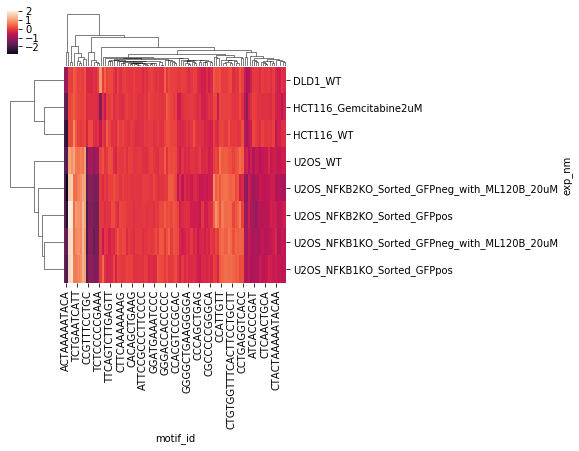

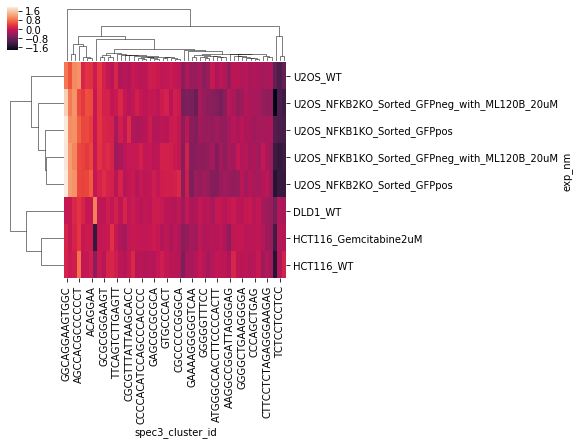

In [65]:
clustering_names = ["motif_id", "spec3_cluster_id"]
for clustering in clustering_names:
    mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
    deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
    deltas_by_cluster = deltas_stacked.unstack(level="exp_nm")
    deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
    motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
    deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")

    from scipy.spatial import distance
    from scipy.cluster import hierarchy

    correlations = deltas_exemplar_exp
    correlations_array = correlations

    row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

    col_linkage = hierarchy.linkage(
        distance.pdist(correlations_array.T), method='average')

    p = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
                       #row_colors=np.arange(len(row_linkage))+1,col_colors=np.arange(len(col_linkage))+1,
                       method="average",
                   figsize=(5,5))#, cmap=cmap)
    

    #p1 = sns.clustermap(data =deltas_exemplar_exp)



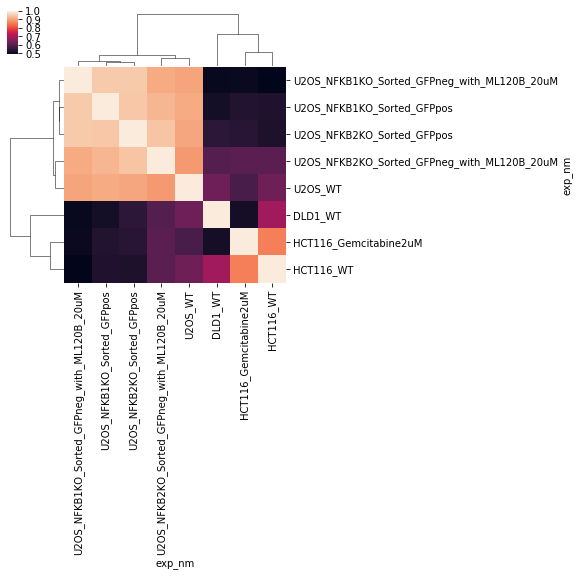

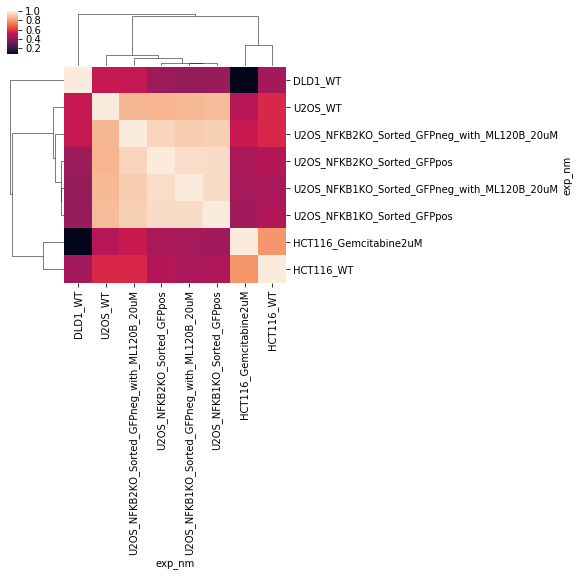

In [67]:
clustering_names = ["motif_id", "spec3_cluster_id"]
for clustering in clustering_names:
    mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
    deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
    deltas_by_cluster = deltas_stacked.unstack(level="exp_nm")
    deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
    motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
    deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")

    from scipy.spatial import distance
    from scipy.cluster import hierarchy

    correlations = deltas_exemplar_exp.T.corr()
    correlations_array = correlations

    row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

    col_linkage = hierarchy.linkage(
        distance.pdist(correlations_array.T), method='average')

    p = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
                       #row_colors=np.arange(len(row_linkage))+1,col_colors=np.arange(len(col_linkage))+1,
                       method="average",
                   figsize=(5,5))#, cmap=cmap)
    

    #p1 = sns.clustermap(data =deltas_exemplar_exp)



In [ ]:
clustering_names = ["motif_id", "spec3_cluster_id"]
for clustering in clustering_names:
    mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
    deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
    deltas_by_cluster = deltas_stacked.unstack(level="exp_nm")
    deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
    motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
    deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")

    from scipy.spatial import distance
    from scipy.cluster import hierarchy

    correlations = deltas_exemplar_exp
    correlations_array = correlations

    row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

    col_linkage = hierarchy.linkage(
        distance.pdist(correlations_array.T), method='average')

    p = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
                       #row_colors=np.arange(len(row_linkage))+1,col_colors=np.arange(len(col_linkage))+1,
                       method="average",
                   figsize=(13, 13))#, cmap=cmap)
    

    #p1 = sns.clustermap(data =deltas_exemplar_exp)



<Figure size 432x288 with 0 Axes>

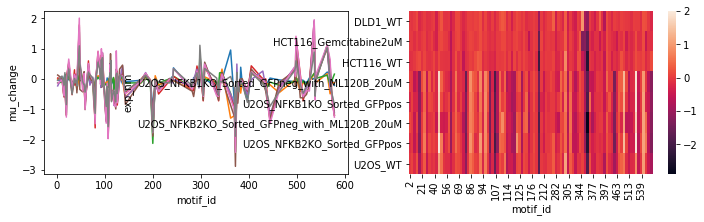

<Figure size 432x288 with 0 Axes>

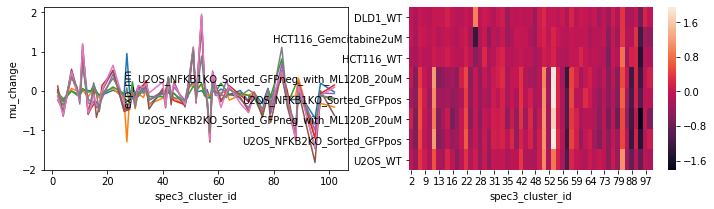

<Figure size 432x288 with 0 Axes>

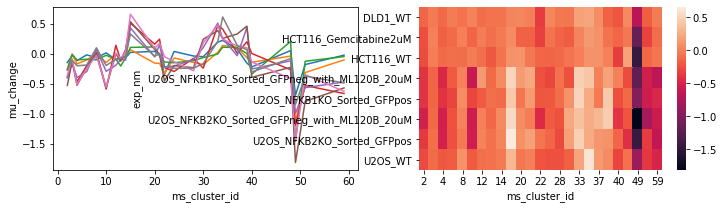

<Figure size 432x288 with 0 Axes>

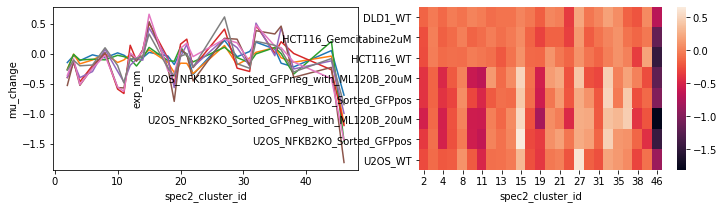

In [48]:
for clustering in ["motif_id","spec3_cluster_id","ms_cluster_id", "spec2_cluster_id",]:
    plt.figure()
    f,subs = plt.subplots(1,2)
    f.set_size_inches(12,3)
    mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
    deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
    deltas_by_cluster = deltas_stacked.unstack(level="exp_nm")
    plt.sca(subs[0])
    g = sns.lineplot(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
    #g._legend.remove()
    g.legend().set_visible(False)
    plt.sca(subs[1])
    
    sns.heatmap(data = deltas_stacked.unstack(level=0).fillna(0))
    
    #plt.legend(loc=[1,0])


<Figure size 576x360 with 0 Axes>

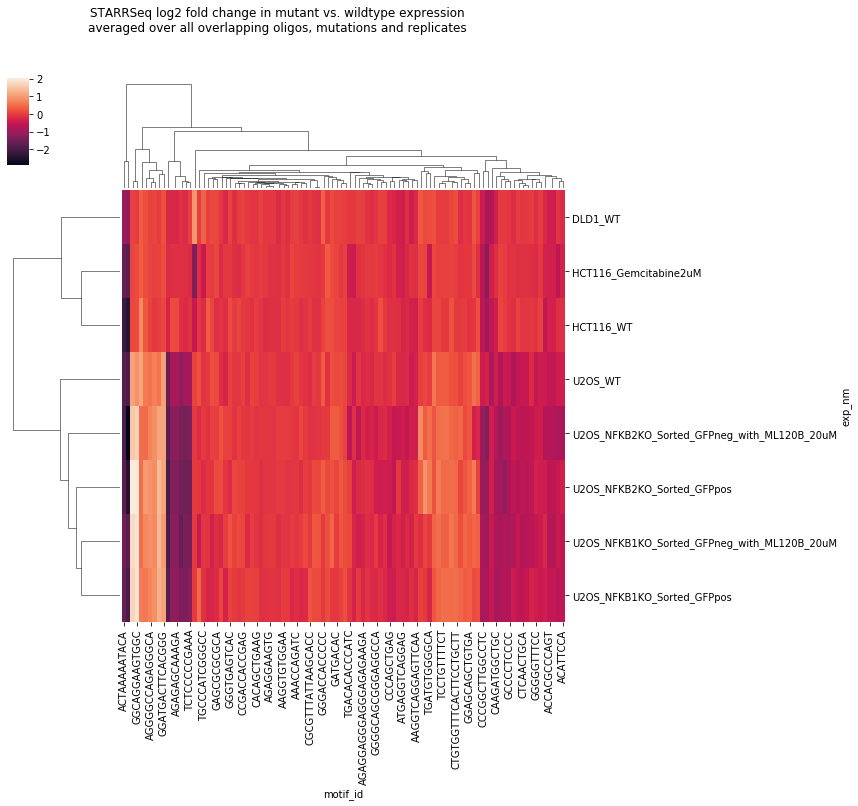

<Figure size 576x360 with 0 Axes>

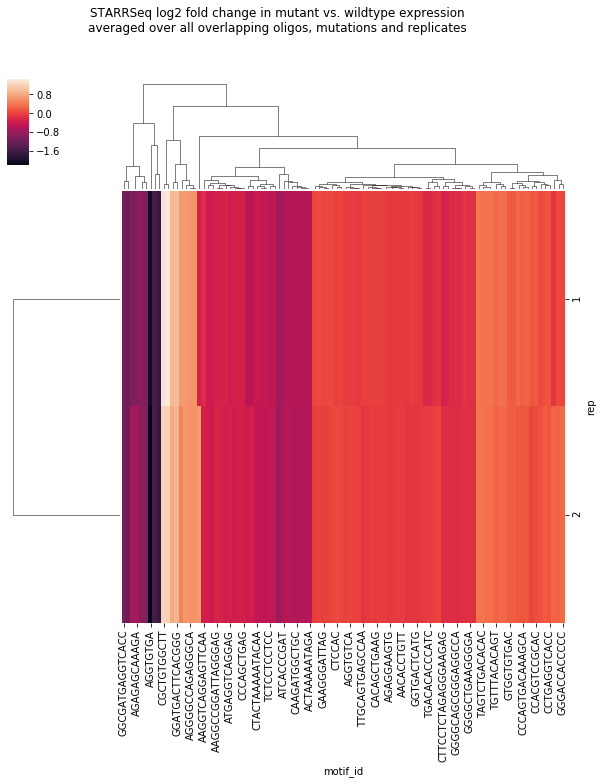

<Figure size 432x288 with 0 Axes>

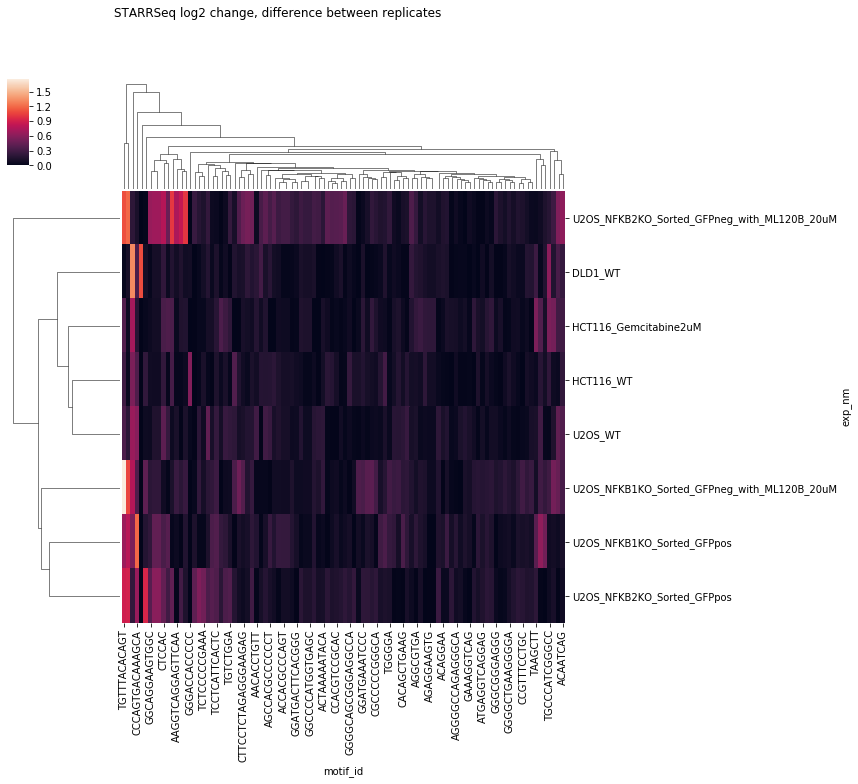

<Figure size 432x288 with 0 Axes>

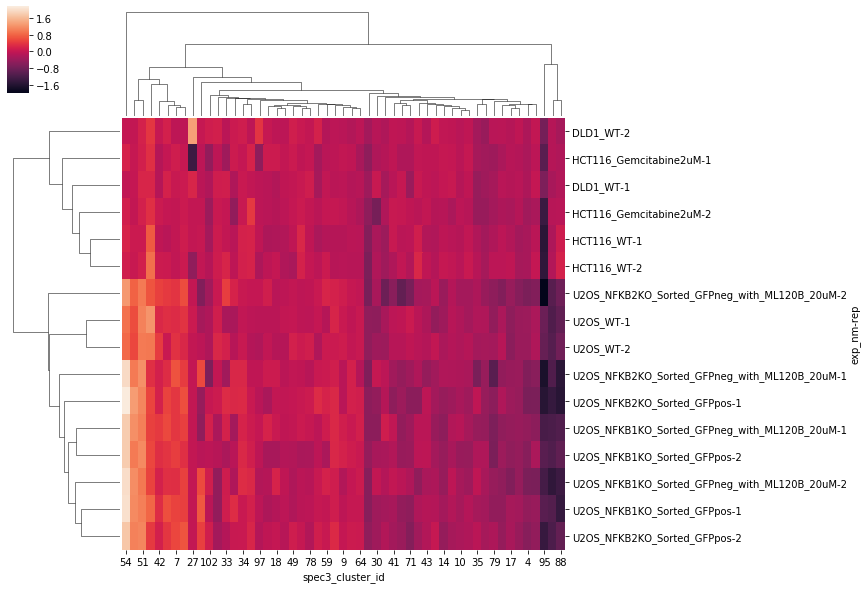

<Figure size 432x288 with 0 Axes>

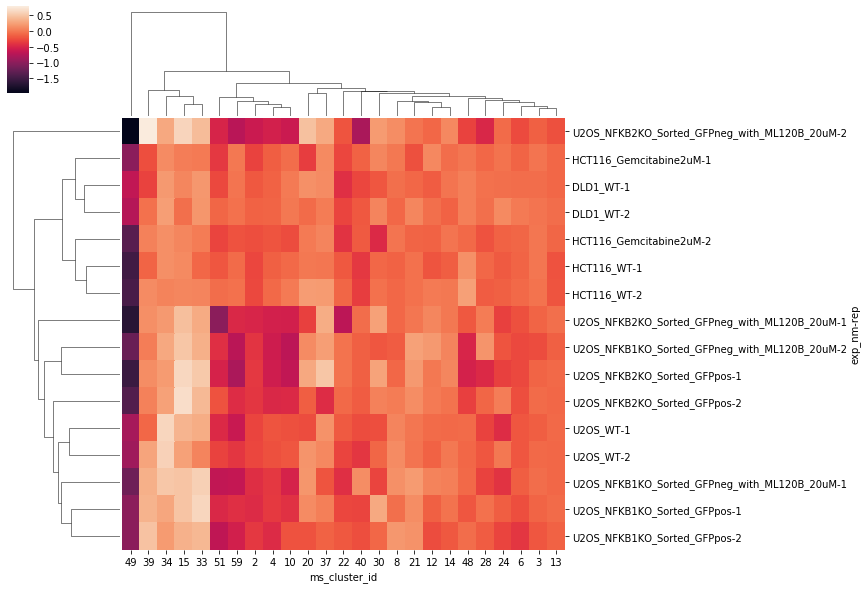

In [50]:
clustering = "motif_id"
f = plt.figure()
f.set_size_inches(8,5)
mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 fold change in mutant vs. wildtype expression\naveraged over all overlapping oligos, mutations and replicates")


clustering = "motif_id"
f = plt.figure()
f.set_size_inches(8,5)
mus_by_cluster = melted.groupby([clustering,"rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 fold change in mutant vs. wildtype expression\naveraged over all overlapping oligos, mutations and replicates")




clustering = "motif_id"
plt.figure()

mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_unstacked_twice = (np.abs(deltas_stacked.unstack(level="rep")[2] - deltas_stacked.unstack(level="rep")[1])).rename("rep_change")

#deltas_by_cluster = deltas_unstacked_twice.unstack(level=["exp_nm"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_unstacked_twice.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 change, difference between replicates")

#p1.set_xlabels(motif_lookup.)

clustering = "spec3_cluster_id"
plt.figure()
mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm","rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])
sns.clustermap(data = deltas_stacked.unstack(level=0).fillna(0))


clustering = "ms_cluster_id"
plt.figure()
mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm","rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])
sns.clustermap(data = deltas_stacked.unstack(level=0).fillna(0))




In [ ]:
import seaborn as sns

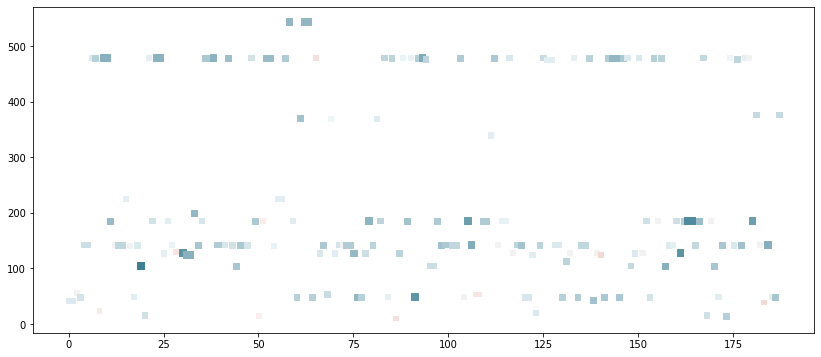

In [51]:
f = plt.gcf()
f.set_size_inches(14,6)

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

ax = plt.gca()
ax.scatter(
    y=r60_max_centroids,
    x=range(len(r60_max_centroids)),
    s=r60_motif_scores / max(r60_motif_scores)*50,
    c=((r60_motif_scores / max(r60_motif_scores) - .5)*2).astype(float).apply(value_to_color), # Vector of square color values, mapped to color palette
    marker='s'
)